In [ ]:
#Initial imports

import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
df= pd.read_csv("ExtractedTweets.csv")
df.head(20)


,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...


In [2]:
df.isna().sum()

Party     0
Handle    0
Tweet     0
dtype: int64

In [3]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [4]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['Tweet']=df['Tweet'].apply(denoise_text)

C:\Users\bayan\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\bayan\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [5]:
words = []
for i in df.Tweet.values:
    words.append(i.split())
words[:5]

[['Today,',
  'Senate',
  'Dems',
  'vote',
  '#SaveTheInternet.',
  'Proud',
  'support',
  'similar',
  '#NetNeutrality',
  'legislation',
  'House…'],
 ['RT',
  '@WinterHavenSun:',
  'Winter',
  'resident',
  'Alta',
  'Vista',
  'teacher',
  'one',
  'several',
  'recognized',
  '@RepDarrenSoto',
  'National',
  'Teacher',
  'Apprecia…'],
 ['RT',
  '@NBCLatino:',
  '.@RepDarrenSoto',
  'noted',
  'Hurricane',
  'Maria',
  'left',
  'approximately',
  '$90',
  'billion',
  'damages.',
  'Congress',
  'allocated',
  '$18…'],
 ['RT',
  '@NALCABPolicy:',
  'Meeting',
  '@RepDarrenSoto',
  'Thanks',
  'taking',
  'time',
  'meet',
  '@LatinoLeader',
  'ED',
  'Marucci',
  'Guzman.',
  '#NALCABPolicy2018.…'],
 ['RT',
  '@Vegalteno:',
  'Hurricane',
  'season',
  'starts',
  'June',
  '1st;',
  'Puerto',
  'Rico’s',
  'readiness...well',
  '🤦🏼\u200d♂️😡😩@Pwr4PuertoRico',
  '@RepDarrenSoto',
  '@EspaillatNY']]

In [6]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [7]:
#vocab size
vocab_size = len(w2v_model.wv.index_to_key)

In [8]:
vocab_size

128273

In [9]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 20)


In [10]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [11]:
def get_weight_matrix(model, vocab):
    # get the number of words in the vocab
    vocab_size = len(vocab) + 1
    
    # create an empty weight matrix
    weight_matrix = np.zeros((vocab_size, model.vector_size))
    
    # loop through the vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

# Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


In [12]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

C:\Users\bayan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           22883000  
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 23,275,706
Trainable params: 23,275,706
Non-trainable params: 0
_________________________________________________________________


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, df.Party , test_size = 0.3 , random_state = 0) 

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)



In [16]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
473/473 [==============================] - 169s 337ms/step - loss: 0.5028 - acc: 0.7348 - val_loss: 0.4330 - val_acc: 0.7907
Epoch 2/3
473/473 [==============================] - 167s 352ms/step - loss: 0.2783 - acc: 0.8748 - val_loss: 0.4787 - val_acc: 0.7874
Epoch 3/3
473/473 [==============================] - 171s 362ms/step - loss: 0.1824 - acc: 0.9169 - val_loss: 0.6337 - val_acc: 0.7802


In [17]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

1892/1892 [==============================] - 26s 13ms/step - loss: 0.1232 - acc: 0.9501
Accuracy of the model on Training Data is -  95.0117290019989
811/811 [==============================] - 11s 13ms/step - loss: 0.6337 - acc: 0.7802
Accuracy of the model on Testing Data is -  78.02451848983765


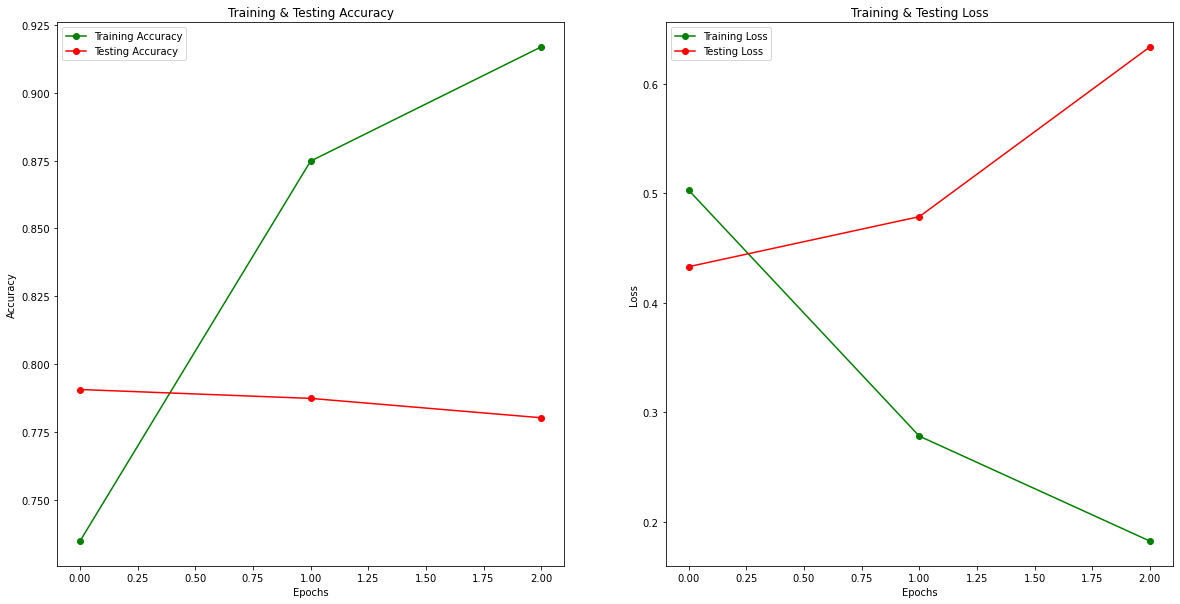

In [18]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
pred_probs = model.predict(x_test)
pred = np.argmax(pred_probs, axis=-1)
pred[:5]


811/811 [==============================] - 11s 13ms/step


array([0, 1, 0, 0, 0], dtype=int64)

In [21]:
x_train,x_test,y_train,y_test = train_test_split(df.Tweet,df.Party, test_size = 0.3 , random_state = 0)

In [22]:
max_features = 35000
maxlen = 200


In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [24]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [25]:
EMBEDDING_FILE = "glove.6B.300d.txt"

In [26]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [27]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\Users\bayan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [28]:
batch_size = 128
epochs = 2
embed_size = 200

In [29]:
model = Sequential()
# Non-trainable embedding layer
model.add(Embedding(nb_words, output_dim=300, weights=[embedding_matrix], input_length=200, trainable=True))
# LSTM 
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['acc'])


C:\Users\bayan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [34]:
model = Sequential()
model.add(Embedding(nb_words, output_dim=300, weights=[embedding_matrix], input_length=200, trainable=True))
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\bayan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 300)          10500000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 10,939,810
Trainable params: 10,939,810
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# one-hot encode y_train and y_test if they are categorical
if len(np.unique(y_train)) > 2:
    y_train = pd.get_dummies(y_train)
if len(np.unique(y_test)) > 2:
    y_test = pd.get_dummies(y_test)

history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=2)


 13/473 [..............................] - ETA: 1:08:27 - loss: 0.8040 - accuracy: 0.5186

KeyboardInterrupt: 

In [37]:
x_train.shape


(25938, 25433)

In [40]:
x_test.shape

(25938, 25433)

In [38]:
y_train.shape

(60522, 2)

In [39]:
y_test.shape


(25938, 2)